<a href="https://colab.research.google.com/github/TheTrigun99/PorjetDATAsciencesSant-S6/blob/main/RLsurglioma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
download.file("http://biodev.cea.fr/sgcca/gliomaData_0.4.tar.gz", destfile = "gliomaData_0.4.tar.gz")

# Installez le package à partir du fichier tar.gz
install.packages("gliomaData_0.4.tar.gz", repos = NULL, type = "source")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
#Mettre ici les packages à installer
install.packages('glmnet')
install.packages('ggplot2')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘iterators’, ‘foreach’, ‘shape’, ‘RcppEigen’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
install.packages('genlasso')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘igraph’




In [ ]:
#import des libraries
library(gliomaData)
library(ggplot2)
library(glmnet)
data(CGH_annot)
data(GE_annot)
data(ge_cgh_locIGR)
head(ge_cgh_locIGR$multiblocks$GE)

Loading required package: Matrix

Loaded glmnet 4.1-8



,A_23_P212522,A_32_P30710,A_24_P470079,A_23_P65830,A_23_P109143,A_24_P932757,A_24_P835500,A_23_P54340,A_23_P67555,A_24_P229084,⋯,A_23_P123563,A_24_P268786,A_23_P356585,A_23_P163455,A_23_P203920,A_24_P9321,A_23_P123596,A_24_P246351,A_23_P5757,A_23_P164289
P01,0.8936004,1.3889304,1.1065010,-0.3418221,-1.951747,3.968026,1.840714,-0.4352272,1.227090242,-0.56106504,⋯,0.4820184,1.2709431,-2.419425,-4.245059,-0.6554781,1.2317241,1.978352,-0.6976348,1.6387925,-0.52752937
P02,-0.5489472,1.3447079,1.4767414,-0.3137007,-2.093880,2.901523,1.977053,-3.6580940,1.217816271,-0.38342092,⋯,0.6646467,0.3576290,-3.741220,-3.156260,1.8996671,2.5289204,2.122445,-3.3318371,1.2036567,0.39865098
P03,-0.5897337,1.3165264,0.9114395,-0.2093412,-2.155131,5.351092,2.207410,0.1527142,0.398369876,-0.23518259,⋯,0.4479681,0.4502204,-3.474260,-4.120701,-0.2077599,0.8692196,1.980582,-0.5674536,1.9670775,0.27330022
P04,-1.0909566,0.9850408,0.6087683,-0.4859501,-2.795157,5.056986,3.601933,-0.1911857,0.114981238,-0.67206971,⋯,0.4306396,1.1514024,-3.932202,-3.587533,-0.7618780,0.3705686,2.078299,-1.0348069,1.1631123,-0.02463044
P05,-0.9548614,1.3667502,0.1880937,-0.3834548,-2.183782,4.205332,2.380681,-1.9796158,0.570008009,-0.35922029,⋯,0.5462385,0.1315505,-2.281168,-2.929421,0.2494818,0.2338792,1.327637,-1.4208879,0.7388536,-0.77857333
P06,0.7715875,1.0574086,1.3835502,-1.1788331,-2.345309,4.939042,4.240646,-0.8738105,0.004701208,-0.09501015,⋯,0.2972649,0.3503109,-5.165508,-4.916707,-2.1401023,1.9714530,1.387142,-2.4998075,1.4791980,1.00338903


Ici on va utiliser le package glmnet pour faire des LASSO avec régréssion logistique, mais on commence par utiliser le cadre des blocks pour nos données **hétérogènes**

In [ ]:
blocks <- ge_cgh_locIGR$multiblocks
Loc <- factor(ge_cgh_locIGR$y)
levels(Loc) <- colnames(ge_cgh_locIGR$multiblocks$y)
blocks[[3]] <- Loc
sapply(blocks, dim)
y = blocks[[3]]
x2 <- blocks[[1]]
get_top_variables <- function(x, n = 20) {
  if (is.null(colnames(x))) {
    stop("Le bloc ne contient pas de noms de variables (pas de noms de colonnes).")
  }

  # Renvoyer les n premiers noms de colonnes
  head(colnames(x), n)
}

# Application à x2
top_vars <- get_top_variables(x2, 20)
print(top_vars)

$GE
[1]    53 15702

$CGH
[1]   53 1229

$y
NULL

 [1] "A_23_P212522" "A_32_P30710"  "A_24_P470079" "A_23_P65830"  "A_23_P109143"
 [6] "A_24_P932757" "A_24_P835500" "A_23_P54340"  "A_23_P67555"  "A_24_P229084"
[11] "A_23_P202696" "A_24_P927716" "A_23_P124837" "A_24_P329635" "A_23_P137931"
[16] "A_23_P203819" "A_24_P687"    "A_23_P253052" "A_23_P201647" "A_24_P350557"


On va tester 3 chemins: \
Un chemin où on prédit y = (localisation de la tumeur) avec CGH_annot \
Un chemin où on prédit y avec GE_annot \
Un chemin où on prédit y avec GE_annot combiné à CGH_annot

Chemin numéro 1:

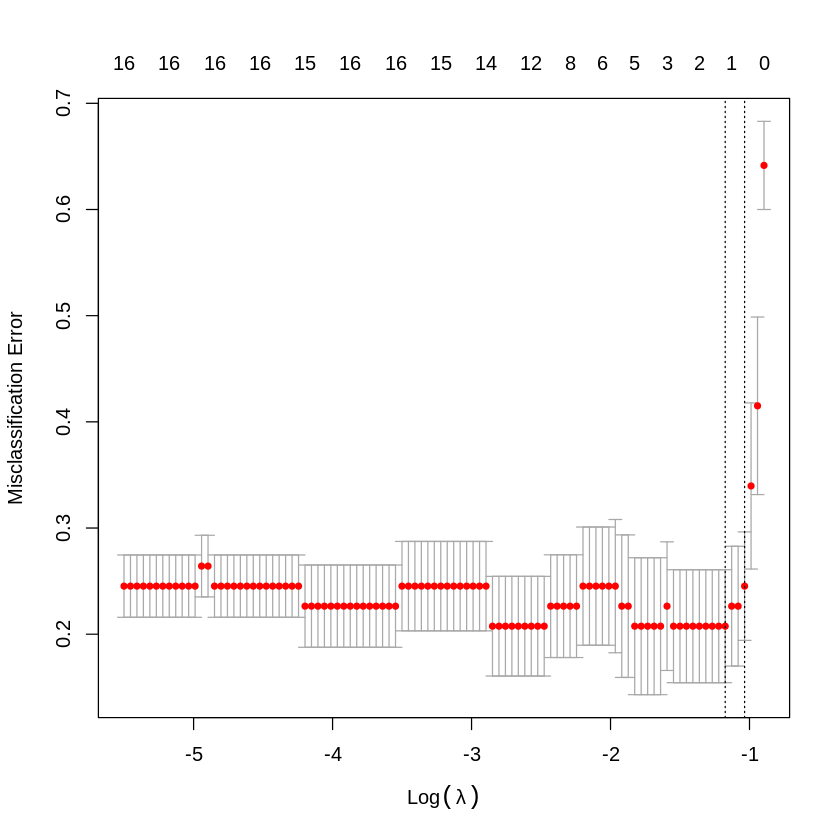

In [ ]:
#Ici on fait le modèle et on affiche le graphe des lambdas (détermination du parmaètre dans le LASSO)

x1 <- blocks[[1]]

cv.lasso <- cv.glmnet(x1, y, alpha = 1,type.measure = "class", family = "multinomial")
plot(cv.lasso)
#par défaut la fonction cv.glmnet effectue une cross validation avec 10 plis

Maintenant, on prédit et on regarde les résultats à l'aide du modèle 1, y prédit avec le block GE

pred
cort dipg 
  26   27 

     class     variable  coefficient
1     cort  (Intercept) -0.002364755
1366  cort A_23_P315122 -0.082312868
7436  cort   A_23_P2293  0.049602707
8807  cort A_23_P313981 -0.313093363
11    dipg  (Intercept)  0.470381118
262   dipg A_23_P205428  0.090993978
12    midl  (Intercept) -0.468016363


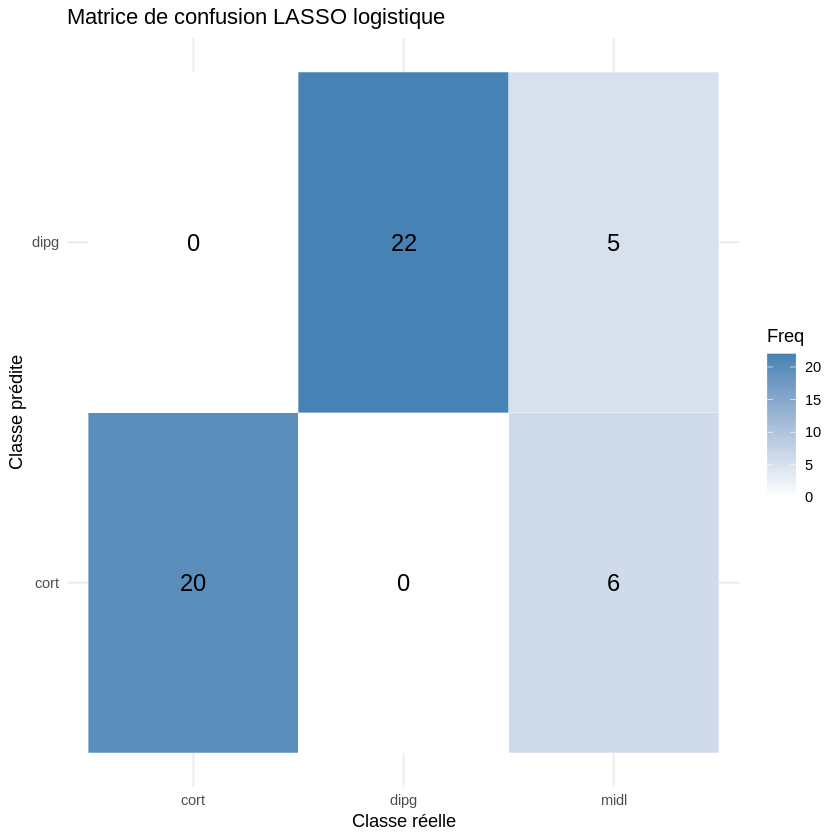

In [ ]:

pred <- predict(cv.lasso, newx = x1, s = "lambda.min", type = "class")
pred <- as.factor(pred)
table(pred)
# Matrice de confusion
conf_df <- as.data.frame(table(Vraie = y, Predite = pred))

# Affichage graphique
ggplot(conf_df, aes(x = Vraie, y = Predite, fill = Freq)) +
  geom_tile(color = "white") +
  geom_text(aes(label = Freq), color = "black", size = 5) +
  scale_fill_gradient(low = "white", high = "steelblue") +
  labs(title = "Matrice de confusion LASSO logistique",
       x = "Classe réelle", y = "Classe prédite") +
  theme_minimal()
coefs_list <- coef(cv.lasso, s = "lambda.min")

# Pour chaque classe, extraire les coefficients non nuls
coefs_df <- do.call(rbind, lapply(names(coefs_list), function(class_name) {
  mat <- as.matrix(coefs_list[[class_name]])
  df <- data.frame(
    class = class_name,
    variable = rownames(mat),
    coefficient = mat[,1],
    row.names = NULL
  )
  subset(df, coefficient != 0)
}))

# Affichage
print(coefs_df)

Ici on a affiché un résultat, mais en réalité en rééxécutant le modèle (code plus haut) on tombe sur des résultats variables. On peut utiliser $set.seed$ mais ça n'empêche que le modèle est instable sur le set de donnée GE.

Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”
Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”
Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”
Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”
Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”
Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dang

Accuracy moyenne sur 5 folds : 0.376 

     Classe Sensibilité Spécificité
cort   cort       0.517       0.490
dipg   dipg       0.470       0.566
midl   midl       0.000       0.953
Accuracy moyenne sur 100 itérations (validation croisée) : 0.019 

     Classe Sensibilité Spécificité
cort   cort       0.026       0.025
dipg   dipg       0.024       0.028
midl   midl       0.000       0.048
     class    variable   coefficient
1     cort (Intercept)  3.127797e-01
32    cort          34 -8.180489e-01
231   cort         255  6.823890e-02
342   cort         382  8.463128e-01
348   cort         389  1.844271e-01
436   cort         484 -1.563567e+00
660   cort         762  2.621400e-01
718   cort         826 -4.529661e-01
11    dipg (Intercept)  9.203855e-02
90    dipg         103 -5.459647e-01
91    dipg         104 -2.736295e-15
128   dipg         146 -2.505445e+00
143   dipg         162 -1.154530e+00
144   dipg         163 -5.368029e-15
222   dipg         246 -2.183535e-04
252   dipg    

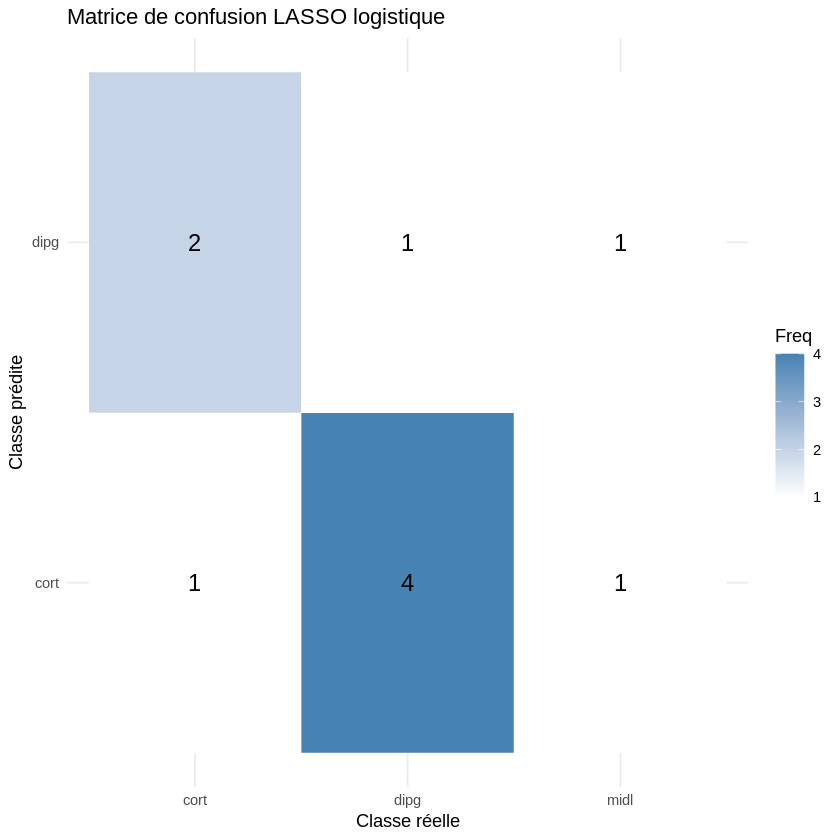

In [ ]:
library(glmnet)

set.seed(123)  # Pour la reproductibilité

x2 <- blocks[[2]]
n <- nrow(x2)
k <- 5  # nombre de folds
folds <- sample(rep(1:k, length.out = n))

classes <- levels(y)
n_classes <- length(classes)

# Initialisation des métriques cumulées
sens_total <- setNames(rep(0, n_classes), classes)
spec_total <- setNames(rep(0, n_classes), classes)
accuracy_tot <- 0
nb_valid_folds <- 0  # compteur pour les folds valides

for (i in 1:k) {
  idx_test <- which(folds == i)
  idx_train <- setdiff(1:n, idx_test)

  x_train <- x2[idx_train, ]
  y_train <- y[idx_train]
  x_test <- x2[idx_test, ]
  y_test <- y[idx_test]

  # Vérifie qu'aucune classe n'est trop petite
  y_train_table <- table(y_train)
  if (any(y_train_table < 8)) {
    next
  }

  cv.lasso <- cv.glmnet(x_train, y_train, alpha = 1, family = "multinomial", type.measure = "class")
  pred <- predict(cv.lasso, newx = x_test, s = "lambda.min", type = "class")
  pred <- as.factor(pred)

  conf_df <- as.data.frame(table(Vraie = y_test, Predite = pred))

  correct <- sum(conf_df$Freq[as.character(conf_df$Vraie) == as.character(conf_df$Predite)])
  total <- sum(conf_df$Freq)
  accuracy <- correct / total
  accuracy_tot <- accuracy_tot + accuracy
  nb_valid_folds <- nb_valid_folds + 1

  for (cls in classes) {
    TP <- sum(conf_df$Freq[conf_df$Vraie == cls & conf_df$Predite == cls])
    FN <- sum(conf_df$Freq[conf_df$Vraie == cls & conf_df$Predite != cls])
    FP <- sum(conf_df$Freq[conf_df$Vraie != cls & conf_df$Predite == cls])
    TN <- sum(conf_df$Freq[conf_df$Vraie != cls & conf_df$Predite != cls])

    sens <- if ((TP + FN) == 0) NA else TP / (TP + FN)
    spec <- if ((TN + FP) == 0) NA else TN / (TN + FP)

    sens_total[cls] <- sens_total[cls] + ifelse(is.na(sens), 0, sens)
    spec_total[cls] <- spec_total[cls] + ifelse(is.na(spec), 0, spec)
  }
}

# Moyennes
accuracy_moy <- accuracy_tot / nb_valid_folds
sens_moy <- sens_total / nb_valid_folds
spec_moy <- spec_total / nb_valid_folds

# Résultats
results_df <- data.frame(
  Classe = classes,
  Sensibilité = round(sens_moy, 3),
  Spécificité = round(spec_moy, 3)
)

cat("Accuracy moyenne sur", nb_valid_folds, "folds :", round(accuracy_moy, 3), "\n\n")
print(results_df)


# Moyennes sur les 100 itérations
accuracy_moy <- accuracy_tot / 100
sens_moy <- sens_total / 100
spec_moy <- spec_total / 100

# Résultat en tableau
results_df <- data.frame(
  Classe = classes,
  Sensibilité = round(sens_moy, 3),
  Spécificité = round(spec_moy, 3)
)

cat("Accuracy moyenne sur 100 itérations (validation croisée) :", round(accuracy_moy, 3), "\n\n")
print(results_df)


# Affichage graphique
ggplot(conf_df, aes(x = Vraie, y = Predite, fill = Freq)) +
  geom_tile(color = "white") +
  geom_text(aes(label = Freq), color = "black", size = 5) +
  scale_fill_gradient(low = "white", high = "steelblue") +
  labs(title = "Matrice de confusion LASSO logistique",
       x = "Classe réelle", y = "Classe prédite") +
  theme_minimal()

coefs_list <- coef(cv.lasso, s = "lambda.min")

# Pour chaque classe, extraire les coefficients non nuls
coefs_df <- do.call(rbind, lapply(names(coefs_list), function(class_name) {
  mat <- as.matrix(coefs_list[[class_name]])
  df <- data.frame(
    class = class_name,
    variable = rownames(mat),
    coefficient = mat[,1],
    row.names = NULL
  )
  subset(df, coefficient != 0)
}))

# Affichage
print(coefs_df)

Ici on prédit y avec CGH, après quelques éxécutions on voit que le modèle est déjà plus stable.

Essayons maintenant de combiner les résultats obtenus pour ces deux blocs.

In [ ]:
#x_combined = blocks[[1]]

library(glmnet)
library(ggplot2)

set.seed(123)

x_combined <- cbind(blocks[[1]], blocks[[2]])
n <- nrow(x_combined)
y <- factor(y)  # S'assurer que y est bien un facteur
classes <- levels(y)
n_classes <- length(classes)

# Initialisation des métriques
sens_total <- setNames(rep(0, n_classes), classes)
spec_total <- setNames(rep(0, n_classes), classes)
accuracy_tot <- 0

K <- 5  # Nombre de folds
n_iter <- 100

for (i in 1:n_iter) {
  folds <- sample(rep(1:K, length.out = n))

  for (k in 1:K) {
    idx_test <- which(folds == k)
    idx_train <- setdiff(1:n, idx_test)

    x_train <- x_combined[idx_train, ]
    y_train <- y[idx_train]
    x_test <- x_combined[idx_test, ]
    y_test <- y[idx_test]

    # Skip si trop peu d’observations dans une classe
    if (any(table(y_train) < 8)) next

    cv.lasso <- cv.glmnet(x_train, y_train, alpha = 1, type.measure = "class", family = "multinomial")
    pred <- predict(cv.lasso, newx = x_test, s = "lambda.min", type = "class")
    pred <- factor(pred, levels = classes)

    conf_df <- as.data.frame(table(Vraie = y_test, Predite = pred))

    # Accuracy
    correct <- sum(conf_df$Freq[as.character(conf_df$Vraie) == as.character(conf_df$Predite)])
    total <- sum(conf_df$Freq)
    accuracy <- correct / total
    accuracy_tot <- accuracy_tot + accuracy

    # Sensibilité et spécificité
    for (cls in classes) {
      TP <- sum(conf_df$Freq[conf_df$Vraie == cls & conf_df$Predite == cls])
      FN <- sum(conf_df$Freq[conf_df$Vraie == cls & conf_df$Predite != cls])
      FP <- sum(conf_df$Freq[conf_df$Vraie != cls & conf_df$Predite == cls])
      TN <- sum(conf_df$Freq[conf_df$Vraie != cls & conf_df$Predite != cls])

      sens <- if ((TP + FN) == 0) NA else TP / (TP + FN)
      spec <- if ((TN + FP) == 0) NA else TN / (TN + FP)

      sens_total[cls] <- sens_total[cls] + ifelse(is.na(sens), 0, sens)
      spec_total[cls] <- spec_total[cls] + ifelse(is.na(spec), 0, spec)
    }
  }
}

# Moyennes
n_total_iter <- K * n_iter
accuracy_moy <- accuracy_tot / n_total_iter
sens_moy <- sens_total / n_total_iter
spec_moy <- spec_total / n_total_iter

# Résultats en tableau
results_df <- data.frame(
  Classe = classes,
  Sensibilité = round(sens_moy, 3),
  Spécificité = round(spec_moy, 3)
)

cat("Accuracy moyenne sur", n_total_iter, "folds :", round(accuracy_moy, 3), "\n\n")
print(results_df)



Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”
Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”
Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”
Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”
Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”
Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dang

Accuracy moyenne sur 500 folds : 0.66 

     Classe Sensibilité Spécificité
cort   cort       0.806       0.770
dipg   dipg       0.785       0.700
midl   midl       0.092       0.808


On affiche les coefficients non nuls voir ce que ça donne

In [ ]:
coefs_list <- coef(cv.lasso, s = "lambda.min")

# Pour chaque classe on a affiche
coefs_df <- do.call(rbind, lapply(names(coefs_list), function(class_name) {
  mat <- as.matrix(coefs_list[[class_name]])
  df <- data.frame(
    class = class_name,
    variable = rownames(mat),
    coefficient = mat[,1],
    row.names = NULL
  )
  subset(df, coefficient != 0)
}))

# Affichage
print(coefs_df)

      class     variable  coefficient
1      cort  (Intercept) -2.251633589
1366   cort A_23_P315122 -0.306553306
2774   cort A_23_P131428 -0.313076131
2775   cort A_23_P138328 -2.376699109
2781   cort  A_23_P46429 -0.153909333
3677   cort A_23_P323272  0.236680910
5602   cort  A_23_P79217 -0.718413825
5819   cort  A_23_P50535  0.042719960
8277   cort  A_23_P66635  0.184272603
8372   cort A_23_P302060 -0.194033790
8807   cort A_23_P313981 -0.695555025
10622  cort A_24_P182764  0.214176131
10646  cort  A_23_P97835 -0.333780626
12563  cort  A_23_P99515 -0.151364399
14473  cort A_23_P333029  0.320945971
14911  cort  A_23_P27846  0.055804376
11     dipg  (Intercept)  0.366177808
262    dipg A_23_P205428  0.491989500
350    dipg A_24_P280274 -0.570007952
2649   dipg A_23_P399255 -0.336464411
3189   dipg   A_23_P2489  0.003289949
5079   dipg  A_32_P62106 -0.150792331
7114   dipg  A_23_P31437  0.626587339
7278   dipg A_32_P210572  0.151372539
7530   dipg  A_23_P29152  1.382784451
11625  dipg 

On combine 2 méthodes: Fused Lasso sur CGH et lasso normale sur GE

In [ ]:
library(genlasso)

# Données
data(ge_cgh_locIGR)
blocks <- ge_cgh_locIGR$multiblocks
y <- factor(ge_cgh_locIGR$y)
levels(y) <- colnames(blocks$y)

x1 <- blocks[[1]]  # GE
x2 <- blocks[[2]]  # CGH

Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”
Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”
Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”
Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”
Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”
Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dang

                 variable count
A_23_P315122 A_23_P315122   100
A_23_P313981 A_23_P313981   100
A_23_P205428 A_23_P205428   100
A_23_P323272 A_23_P323272    93
A_23_P399255 A_23_P399255    92
A_32_P62106   A_32_P62106    74
A_23_P131428 A_23_P131428    69
A_32_P210572 A_32_P210572    64
A_23_P327910 A_23_P327910    61
A_23_P2293     A_23_P2293    54
A_23_P374695 A_23_P374695    54
A_23_P99515   A_23_P99515    46
A_23_P333029 A_23_P333029    41
A_23_P31437   A_23_P31437    40
A_23_P421493 A_23_P421493    39
A_23_P409502 A_23_P409502    39
A_23_P252388 A_23_P252388    38
A_23_P37560   A_23_P37560    36
A_23_P114713 A_23_P114713    35
A_23_P390876 A_23_P390876    35
A_23_P48663   A_23_P48663    35
A_23_P138328 A_23_P138328    34
A_23_P46429   A_23_P46429    34
A_23_P27846   A_23_P27846    34
A_23_P32233   A_23_P32233    34
A_23_P129133 A_23_P129133    34
A_23_P6335     A_23_P6335    31
A_23_P66635   A_23_P66635    30
A_24_P182764 A_24_P182764    30
A_23_P79217   A_23_P79217    28
A_23_P29

Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”
Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”
Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”
Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”
Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”
Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dang

                 variable count
A_23_P315122 A_23_P315122   100
A_23_P313981 A_23_P313981   100
A_23_P205428 A_23_P205428   100
A_23_P323272 A_23_P323272    90
A_23_P399255 A_23_P399255    90
A_23_P131428 A_23_P131428    71
A_32_P210572 A_32_P210572    67
A_32_P62106   A_32_P62106    67
A_23_P2293     A_23_P2293    60
A_23_P327910 A_23_P327910    60
A_23_P374695 A_23_P374695    54
A_23_P99515   A_23_P99515    40
A_23_P333029 A_23_P333029    38
A_23_P31437   A_23_P31437    37
A_23_P252388 A_23_P252388    36
A_23_P421493 A_23_P421493    36
A_23_P37560   A_23_P37560    35
A_23_P114713 A_23_P114713    34
A_23_P390876 A_23_P390876    34
A_23_P129133 A_23_P129133    34
A_23_P48663   A_23_P48663    34
A_23_P138328 A_23_P138328    32
A_23_P27846   A_23_P27846    32
A_23_P32233   A_23_P32233    32
A_23_P409502 A_23_P409502    31
A_23_P46429   A_23_P46429    29
A_23_P6335     A_23_P6335    29
A_23_P66635   A_23_P66635    26
A_24_P182764 A_24_P182764    26
A_23_P32847   A_23_P32847    24
A_23_P79

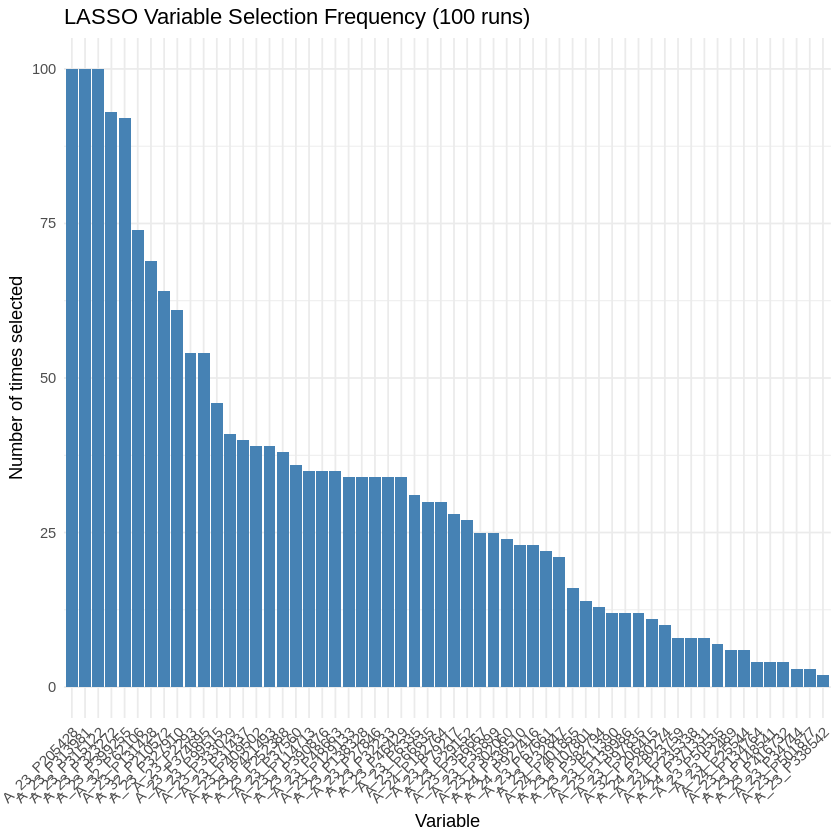

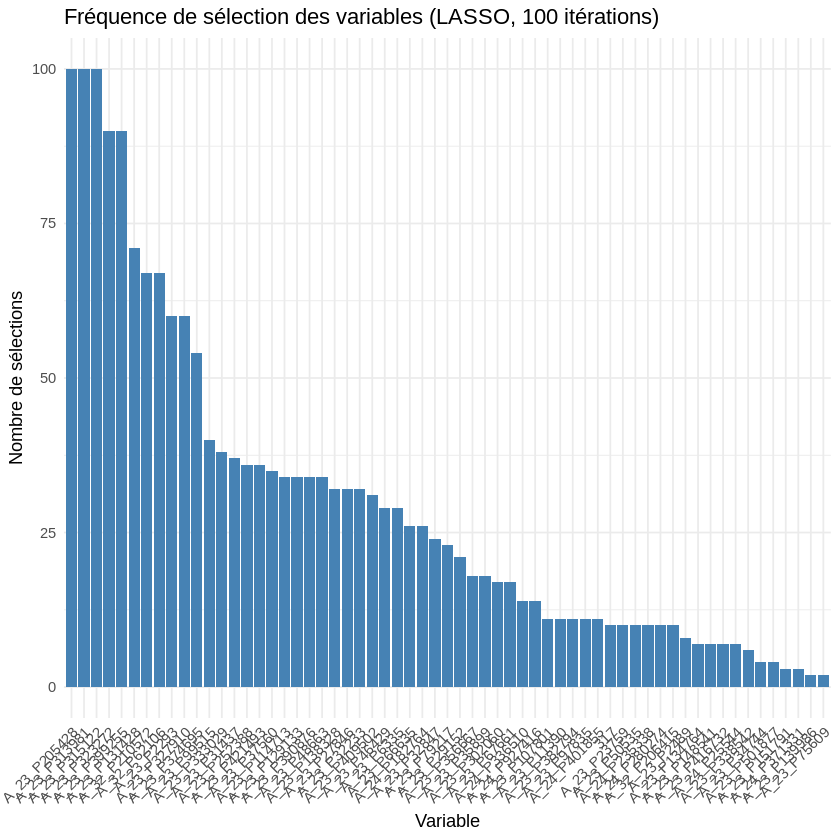

In [ ]:
#boucle pour trouver les paramaètres importants de GE
selection_counts <- list()

for (i in 1:100) {
  cv_lasso <- cv.glmnet(x1, y, family = "multinomial", alpha = 1, type.measure = "class")
  lasso_coefs_list <- coef(cv_lasso, s = "lambda.min")


  selected_vars <- unlist(lapply(names(lasso_coefs_list), function(cl) {
    mat <- as.matrix(lasso_coefs_list[[cl]])
    rownames(mat)[mat[, 1] != 0 & rownames(mat) != "(Intercept)"]
  }))


  for (var in selected_vars) {
    selection_counts[[var]] <- selection_counts[[var]] %||% 0
    selection_counts[[var]] <- selection_counts[[var]] + 1
  }
}


selection_df <- data.frame(
  variable = names(selection_counts),
  count = unlist(selection_counts)
)

stable_vars <- subset(selection_df, count >= 10)

print(stable_vars[order(-stable_vars$count), ])

library(ggplot2)

# Optional: order variables by frequency (descending)
selection_df <- selection_df[order(-selection_df$count), ]

# Plot
ggplot(selection_df, aes(x = reorder(variable, -count), y = count)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  labs(
    title = "LASSO Variable Selection Frequency (100 runs)",
    x = "Variable",
    y = "Number of times selected"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

library(glmnet)
library(ggplot2)

# Combinaison des blocs
x_combined <- cbind(blocks[[1]], blocks[[2]])

# Initialisation
selection_counts <- list()

# Répétition 100 fois pour estimer la stabilité des variables sélectionnées
for (i in 1:100) {
  cv_lasso <- cv.glmnet(x_combined, y, family = "multinomial", alpha = 1, type.measure = "class")
  lasso_coefs_list <- coef(cv_lasso, s = "lambda.min")

  selected_vars <- unlist(lapply(names(lasso_coefs_list), function(cl) {
    mat <- as.matrix(lasso_coefs_list[[cl]])
    rownames(mat)[mat[, 1] != 0 & rownames(mat) != "(Intercept)"]
  }))

  for (var in selected_vars) {
    selection_counts[[var]] <- selection_counts[[var]] %||% 0
    selection_counts[[var]] <- selection_counts[[var]] + 1
  }
}

# Transformation en data frame
selection_df <- data.frame(
  variable = names(selection_counts),
  count = unlist(selection_counts)
)

# Filtrage des variables stables (apparues au moins 10 fois)
stable_vars <- subset(selection_df, count >= 10)

# Affichage des variables les plus fréquentes
print(stable_vars[order(-stable_vars$count), ])

# Préparation du plot
selection_df <- selection_df[order(-selection_df$count), ]

# Visualisation
ggplot(selection_df, aes(x = reorder(variable, -count), y = count)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  labs(
    title = "Fréquence de sélection des variables (LASSO, 100 itérations)",
    x = "Variable",
    y = "Nombre de sélections"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))



In [ ]:

# Encodage y → numérique pour régression multinomiale
# (glmnet le gère directement si y est facteur)

# Modèle 1 : LASSO sur GE
set.seed(42)
cv_lasso <- cv.glmnet(x1, y, family = "multinomial", alpha = 1, type.measure = "class")
pred1 <- predict(cv_lasso, newx = x1, s = "lambda.min", type = "response")

# Modèle 2 : Fused LASSO sur CGH
# On va faire un modèle par classe en one-vs-all
classes <- levels(y)
n <- nrow(x2)
K <- length(classes)
pred2 <- matrix(0, n, K)
colnames(pred2) <- classes

x2_mat <- as.matrix(as.data.frame(x2))

for (k in seq_along(classes)) {
  y_bin <- as.numeric(y == classes[k])
  fit_fused <- fusedlasso1d(y = y_bin, X = x2_mat)
  beta_fused <- coef(fit_fused, lambda = fit_fused$lambda[10])$beta
  pred2[, k] <- x2_mat %*% beta_fused
}



pred2_soft <- exp(pred2)
pred2_soft <- pred2_soft / rowSums(pred2_soft)

# On combine les deux prédictions avec une logistique
# pondération égale des modèles
prob_combined <- (pred1[,,1] + pred2_soft) / 2

y_pred <- apply(prob_combined, 1, function(row) colnames(prob_combined)[which.max(row)])
y_pred <- factor(y_pred, levels = levels(y))

# Matrice de confusion
print(table(Vrai = y, Prédit = y_pred))


ERROR: Error in cv.glmnet(x1, y, family = "multinomial", alpha = 1, type.measure = "class"): could not find function "cv.glmnet"


In [ ]:
#  Coefficients LASSO non nuls pour chaque classe
lasso_coefs_list <- coef(cv_lasso, s = "lambda.min")

lasso_selected <- do.call(rbind, lapply(names(lasso_coefs_list), function(cl) {
  mat <- as.matrix(lasso_coefs_list[[cl]])
  df <- data.frame(
    classe = cl,
    variable = rownames(mat),
    coefficient = mat[, 1],
    row.names = NULL
  )
  subset(df, coefficient != 0 & variable != "(Intercept)")
}))

cat(" Variables sélectionnées par le LASSO (bloc GE) :\n")
print(lasso_selected)

 Variables sélectionnées par le LASSO (bloc GE) :
      classe     variable  coefficient
1366    cort A_23_P315122 -0.265308928
2774    cort A_23_P131428 -0.268998108
2775    cort A_23_P138328 -1.786213960
2781    cort  A_23_P46429 -0.107846615
3677    cort A_23_P323272  0.208362272
5602    cort  A_23_P79217 -0.403755777
7084    cort A_23_P409502 -0.231904672
8277    cort  A_23_P66635  0.091213933
8372    cort A_23_P302060 -0.228911803
8807    cort A_23_P313981 -0.887797497
10622   cort A_24_P182764  0.164597743
10646   cort  A_23_P97835 -0.082342985
12563   cort  A_23_P99515 -0.139584845
14430   cort A_24_P927416 -0.229842448
14473   cort A_23_P333029  0.246345288
14911   cort  A_23_P27846  0.039194457
262     dipg A_23_P205428  0.407978486
350     dipg A_24_P280274 -0.021108252
2649    dipg A_23_P399255 -0.315333255
5079    dipg  A_32_P62106 -0.089861746
7114    dipg  A_23_P31437  0.618377964
7278    dipg A_32_P210572  0.112027328
7530    dipg  A_23_P29152  1.000975541
11625   dipg A

In [ ]:
library(genlasso)     # remplace fusedlasso
set.seed(123)         # reproductibilité

# ────────────────────────────────────────────
#  Préparation des données
# ────────────────────────────────────────────
classes  <- levels(y)
n        <- nrow(x2)
K        <- length(classes)
x2_mat   <- as.matrix(as.data.frame(x2))
p        <- ncol(x2_mat)

# Matrice‑pénalité D : différences première‑ordre entre coefficients voisins
D <- diff(diag(p), differences = 1)

# ────────────────────────────────────────────
#  Conteneur pour compter les sélections
# ────────────────────────────────────────────
select_count <- setNames(integer(p), colnames(x2_mat))

# ────────────────────────────────────────────
#  Boucle principale (100 itérations bootstrap)
# ────────────────────────────────────────────
n_iter <- 10
for (iter in seq_len(n_iter)) {

  ## 1. Bootstrap des observations
  idx_boot <- sample.int(n, size = n, replace = TRUE)
  X_boot   <- x2_mat[idx_boot, , drop = FALSE]
  y_boot   <- y[idx_boot]

  ## 2. Union des variables sélectionnées sur toutes les classes
  selected_vars_this_iter <- logical(p)

  for (k in seq_along(classes)) {
    y_bin <- as.numeric(y_boot == classes[k])

    # Ajustement du modèle genlasso (fused lasso 1D sur les β)
    fit_gen <- genlasso(y = y_bin, X = X_boot, D = D)

    # Choix arbitraire : 10ᵉ valeur de λ (ou la dernière si < 10)
    target_lambda <- if (length(fit_gen$lambda) >= 10) fit_gen$lambda[10] else tail(fit_gen$lambda, 1)
    beta_gen      <- coef(fit_gen, lambda = target_lambda)$beta   # longueur = p

    # Marquer les variables avec |β| > seuil
    selected_vars_this_iter <- selected_vars_this_iter | (abs(beta_gen) > 1e-6)
  }

  ## 3. Incrémenter le compteur
  select_count[selected_vars_this_iter] <- select_count[selected_vars_this_iter] + 1
}

# ────────────────────────────────────────────
#  Résultat final : classement décroissant

result <- data.frame(
  Variable    = names(select_count),
  Appearances = as.integer(select_count),
  Frequency   = select_count / n_iter
)

result <- result[order(-result$Appearances), ]
rownames(result) <- NULL

print(result)

Warning message in genlasso(y = y_bin, X = X_boot, D = D):
“Adding a small ridge penalty (multiplier 0.0001), because X has more columns than rows.”
Warning message in genlasso(y = y_bin, X = X_boot, D = D):
“Adding a small ridge penalty (multiplier 0.0001), because X has more columns than rows.”
Warning message in genlasso(y = y_bin, X = X_boot, D = D):
“Adding a small ridge penalty (multiplier 0.0001), because X has more columns than rows.”
Warning message in genlasso(y = y_bin, X = X_boot, D = D):
“Adding a small ridge penalty (multiplier 0.0001), because X has more columns than rows.”
Warning message in genlasso(y = y_bin, X = X_boot, D = D):
“Adding a small ridge penalty (multiplier 0.0001), because X has more columns than rows.”
Warning message in genlasso(y = y_bin, X = X_boot, D = D):
“Adding a small ridge penalty (multiplier 0.0001), because X has more columns than rows.”
Warning message in genlasso(y = y_bin, X = X_boot, D = D):
“Adding a small ridge penalty (multiplier 0.000